# Mortality prediction notebook
**Description**: This notebook contains the codes to develop models to predict mortality.

**Authors**: Beatriz Lourenço, Sofia Silvestre, Aldo Arévalo.

**Creation date**: 09/08/2021

**Reference**:  Richman, Ronald and Wuthrich, Mario V., *Lee and Carter go Machine Learning: Recurrent Neural Networks* (August 22, 2019). Available at SSRN: https://ssrn.com/abstract=3441030 or http://dx.doi.org/10.2139/ssrn.3441030

# Libraries

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from numpy.random import seed
import tensorflow as tf
from tensorflow.random import set_seed
import pickle

In [3]:
import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [4]:
seed(1)
set_seed(2) #89

In [5]:
"""
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)"""

'\ngpu_devices = tf.config.experimental.list_physical_devices("GPU")\nfor device in gpu_devices:\n    tf.config.experimental.set_memory_growth(device, True)'

In [6]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 8.2 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

#LSTM Configuration
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, LSTM, Flatten, Concatenate, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow_addons.optimizers import  RectifiedAdam, Lookahead
from tensorflow.keras import backend
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


# Optimizer for comparing LSTM vs Lee-Carter
import cvxpy as cp

import pydot
import graphviz

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
#!pip install tensorflow-gpu==2.6.0

In [9]:
#!pip freeze

In [10]:
import os
os.getcwd()

'/content'

# Data Preparation

In [11]:
# Change working directory
os.chdir('/content/drive/My Drive/Colab Notebooks/Tese/mx_insurance')


## **Portuguese** Dataset

In [12]:
dtPT = pd.read_csv('Dataset/Mx_1x1_alt.txt', header=None, sep='\s+', names=["Year", "Age", "mxf", "mxm",'mxTotal'])

In [13]:
dtPT

,Year,Age,mxf,mxm,mxTotal
0,1940,0,0.137274,0.152282,0.145038
1,1940,1,0.047899,0.051148,0.049561
2,1940,2,0.019757,0.019906,0.019833
3,1940,3,0.010181,0.009989,0.010083
4,1940,4,0.006305,0.006830,0.006572
...,...,...,...,...,...
8986,2020,106,0.726775,1.678322,0.793418
8987,2020,107,0.906253,0.000000,0.879679
8988,2020,108,0.251046,.,0.251046
8989,2020,109,0.500518,.,0.500518


In [14]:
Year = []
Age = []
mx = []
Gender = []
for year in range(1940, 2020+1):
  dt = (dtPT[dtPT['Year']==year])
  Year.extend((dt['Year'].to_list())*2)
  Age.extend((dt['Age'].to_list())*2)
  mxf = dt['mxf'].to_list()
  mx.extend(mxf)
  mxm = dt['mxm'].to_list()
  mx.extend(mxm)
  female = ['Female']*(len(mxf))
  Gender.extend(female)
  male = ['Male']*(len(mxm))
  Gender.extend(male)


dataPT = pd.DataFrame({ 'Year': Year, 'Age': Age, 'Gender': Gender, 'mx':mx})
dataPT

,Year,Age,Gender,mx
0,1940,0,Female,0.137274
1,1940,1,Female,0.047899
2,1940,2,Female,0.019757
3,1940,3,Female,0.010181
4,1940,4,Female,0.006305
...,...,...,...,...
17977,2020,106,Male,1.678322
17978,2020,107,Male,0.000000
17979,2020,108,Male,.
17980,2020,109,Male,.


**Missing** **Values**

In [15]:
 dataPT = dataPT[dataPT["mx"] != '.']
 dataPT["mx"] = pd.to_numeric(dataPT["mx"], errors='ignore')
 dataPT

<ipython-input-15-9dcc5a9582e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataPT["mx"] = pd.to_numeric(dataPT["mx"], errors='ignore')


,Year,Age,Gender,mx
0,1940,0,Female,0.137274
1,1940,1,Female,0.047899
2,1940,2,Female,0.019757
3,1940,3,Female,0.010181
4,1940,4,Female,0.006305
...,...,...,...,...
17974,2020,103,Male,0.607595
17975,2020,104,Male,0.737463
17976,2020,105,Male,0.722717
17977,2020,106,Male,1.678322


In [16]:
dataPT

,Year,Age,Gender,mx
0,1940,0,Female,0.137274
1,1940,1,Female,0.047899
2,1940,2,Female,0.019757
3,1940,3,Female,0.010181
4,1940,4,Female,0.006305
...,...,...,...,...
17974,2020,103,Male,0.607595
17975,2020,104,Male,0.737463
17976,2020,105,Male,0.722717
17977,2020,106,Male,1.678322


In [17]:
(dataPT[dataPT['mx'] >1])

,Year,Age,Gender,mx
215,1940,104,Male,1.059197
665,1942,110+,Male,2.021904
885,1943,108,Male,1.333333
887,1943,110+,Male,1.342282
1106,1944,107,Male,1.160731
...,...,...,...,...
17534,2018,107,Male,4.445048
17536,2018,109,Male,4.002131
17648,2019,110+,Female,1.849707
17870,2020,110+,Female,1.112981


In [18]:
dataPT[(dataPT['mx'] == 0.0)].groupby('Age').count()['mx']

Age
100      1
101      9
102      6
103     16
104     22
105     17
106     38
107     36
108     39
109     44
110+    40
13       2
3        1
6        1
Name: mx, dtype: int64

In [19]:
dataPT[(dataPT['mx'] == 0.0)].groupby('Age').count()['mx']

Age
100      1
101      9
102      6
103     16
104     22
105     17
106     38
107     36
108     39
109     44
110+    40
13       2
3        1
6        1
Name: mx, dtype: int64

In [20]:
 count = dataPT[(dataPT['mx'] == 0.0)].groupby('Age').count()['mx'].to_list()

In [21]:
np.array(count)*100/sum(count)

array([ 0.36764706,  3.30882353,  2.20588235,  5.88235294,  8.08823529,
        6.25      , 13.97058824, 13.23529412, 14.33823529, 16.17647059,
       14.70588235,  0.73529412,  0.36764706,  0.36764706])

In [22]:
dataPT["Age"] = pd.to_numeric(dataPT["Age"], errors='coerce')
dataPT=dataPT[dataPT["Age"]<100]

<ipython-input-22-6db6300dd120>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataPT["Age"] = pd.to_numeric(dataPT["Age"], errors='coerce')


In [23]:
dataPT

,Year,Age,Gender,mx
0,1940,0.0,Female,0.137274
1,1940,1.0,Female,0.047899
2,1940,2.0,Female,0.019757
3,1940,3.0,Female,0.010181
4,1940,4.0,Female,0.006305
...,...,...,...,...
17966,2020,95.0,Male,0.341187
17967,2020,96.0,Male,0.404959
17968,2020,97.0,Male,0.454256
17969,2020,98.0,Male,0.412777


In [24]:
num_dataPT = dataPT[dataPT['mx'] == 0]
num_dataPT.groupby(by="Age").count()

,Year,Gender,mx
Age,,,
3.0,1,1,1
6.0,1,1,1
13.0,2,2,2


In [25]:
num_dataPT = dataPT[dataPT['mx'] != '.']
dataPT["mx"] = pd.to_numeric(dataPT["mx"])
dataPT[(dataPT['mx'] == 0)] # 4 valores com 0.0 de mortalidade

<ipython-input-25-4d18f7055b43>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataPT["mx"] = pd.to_numeric(dataPT["mx"])


,Year,Age,Gender,mx
15775,2011,13.0,Female,0.0
16774,2015,13.0,Male,0.0
17208,2017,3.0,Male,0.0
17544,2019,6.0,Female,0.0


In [26]:
years_wd = 2
mv_rows = (dataPT[(dataPT['mx'] == 0)]).index

for row in mv_rows:
  age = (dataPT.loc[row])['Age']
  current_year = dataPT.loc[row]['Year']
  gender =  dataPT.loc[row]['Gender']
  df = (dataPT[ (dataPT['Year'] >= (current_year-years_wd) ) & (dataPT['Year'] <= (current_year+years_wd) ) & (dataPT['Age'] == age) & (dataPT['Gender'] == gender) ] )

  dataPT.at[row, 'mx'] = df['mx'].mean()

In [27]:
dataPT.loc[mv_rows] #imputed values

,Year,Age,Gender,mx
15775,2011,13.0,Female,0.000096
16774,2015,13.0,Male,0.000094
17208,2017,3.0,Male,0.000133
17544,2019,6.0,Female,0.000078


In [28]:
dataPT['logmx'] = np.log(dataPT['mx'])
dataPT

<ipython-input-28-3d7140d355e9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataPT['logmx'] = np.log(dataPT['mx'])


,Year,Age,Gender,mx,logmx
0,1940,0.0,Female,0.137274,-1.985776
1,1940,1.0,Female,0.047899,-3.038661
2,1940,2.0,Female,0.019757,-3.924247
3,1940,3.0,Female,0.010181,-4.587232
4,1940,4.0,Female,0.006305,-5.066412
...,...,...,...,...,...
17966,2020,95.0,Male,0.341187,-1.075325
17967,2020,96.0,Male,0.404959,-0.903969
17968,2020,97.0,Male,0.454256,-0.789094
17969,2020,98.0,Male,0.412777,-0.884848


In [29]:
dataPT.to_csv('Dataset/dataPT.csv', index=False)

## **Swiss** Dataset

In [30]:
dataSW = pd.DataFrame(pd.read_excel("Dataset/CHE_mort.xlsx"))
dataSW.head()

,Gender,Year,Age,Country,imputed_flag,mx,logmx
0,Female,1950,0,CHE,False,0.027293,-3.601125
1,Female,1950,1,CHE,False,0.003046,-5.793926
2,Female,1950,2,CHE,False,0.001674,-6.392539
3,Female,1950,3,CHE,False,0.001234,-6.697494
4,Female,1950,4,CHE,False,0.001007,-6.900780


## Data Choice

In [31]:
data = dataPT.copy()

In [32]:
year_max = data['Year'].max()
year_min = data['Year'].min()

In [33]:
data['mx'].max()

0.970151

# Modeling

## Lee Carter

### Data partition for Lee Carter
Training: years < 2000

Validation: years <= 2000


In [34]:
# Get males and females
male_data = data.loc[data['Gender'] == "Male"].copy()
female_data = data.loc[data['Gender'] == "Female"].copy()

In [35]:
# Split males
male_training_data = male_data[male_data['Year'] < 2000]
male_validation_data = male_data[male_data['Year'] >= 2000]

# Split females
female_training_data = female_data[female_data['Year'] < 2000]
female_validation_data =female_data[female_data['Year'] >= 2000]

In [36]:
# Split data
LC_training_data = data[data['Year'] < 2000]
LC_validation_data = data[data['Year'] >= 2000]

### Model

In [37]:
train_data_male = LC_training_data[ (data['Gender'] == 'Male')]
mean_logmx_by_age_dict_m = train_data_male.groupby(by='Age').agg('mean')['logmx'].to_dict()

train_data_female = LC_training_data[ (data['Gender'] == 'Female')]
mean_logmx_by_age_dict_f = train_data_female.groupby(by='Age').agg('mean')['logmx'].to_dict()

<ipython-input-37-551980ddb984>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_data_male = LC_training_data[ (data['Gender'] == 'Male')]
<ipython-input-37-551980ddb984>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_logmx_by_age_dict_m = train_data_male.groupby(by='Age').agg('mean')['logmx'].to_dict()
<ipython-input-37-551980ddb984>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_data_female = LC_training_data[ (data['Gender'] == 'Female')]
<ipython-input-37-551980ddb984>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  me

In [38]:
def fit_LeeCarter(train_data, gender): #returns the models fitted parameters

  # Get validation Data by gender
  train_data_by_gender = train_data[ (train_data['Gender'] == gender)]

  # Construction of Centered log-Mortality Matrix
  ### Get mean values for log mortality for each age
  mean_logmx_by_age_dict = train_data_by_gender.groupby(by='Age').agg('mean')['logmx'].to_dict()

  ### Add the corresponding log-mortality mean value to each Age in the training data
  train_data_by_gender['ax'] = train_data_by_gender['Age'].map(mean_logmx_by_age_dict)

  ### Add the adjusted mortality value
  train_data_by_gender['mx_adj'] = train_data_by_gender['logmx'] - train_data_by_gender['ax']


  rates_mat=pd.pivot_table(train_data_by_gender, index='Age', columns='Year', values='mx_adj', aggfunc='sum')

  # Singular value decomposition (SVD)
  U, d, V = np.linalg.svd(rates_mat, full_matrices=False )
  V=V.transpose()
  ax = np.array(list(mean_logmx_by_age_dict.values()))
  bx = U[:,0]*d[0]
  kt = V[:,0]

  c1=kt.mean()
  c2=bx.sum()

  # Average log-mortality rate at age x (Lee-Carter formula)
  ax = ax + c1*bx
  # Rate of time for a person aged x (Lee-Carter formula)
  bx = bx / c2
  # Time indexes for the annual mortality rates chage (Lee-Carter formula)
  kt = (kt-c1)*c2

  return ax, bx, kt

In [39]:
def LeeCarter_kt_Forecast(time_steps, kt, show_plot = True): #returns kt forecasting
  year = data['Year'].min()
  t_forecast = time_steps
  model = ARIMA(endog = kt, order = (0, 1, 0))
  fit_model = model.fit()
  kt_forecast = fit_model.forecast(steps=len(t_forecast))

  if show_plot:
    ones_kt_forecast = np.ones((kt_forecast).shape)
    # Plot  kt
    plt.rcParams['figure.figsize']=(20,10)
    plt.rcParams.update({'mathtext.default':  'regular' })
    x = np.append(np.arange(year,2000), t_forecast)
    y = np.append(kt, kt_forecast)
    forecast_col = np.append(np.zeros(len(kt)), ones_kt_forecast)
    plt.scatter(x,y,c=["r" if x == 1 else "b" for x in np.append(np.zeros(len(kt)), ones_kt_forecast)])
    plt.xlabel('Calendar year',fontsize = 16, fontweight='bold')
    plt.ylabel('Values $k_{t}$',fontsize = 16, fontweight='bold')
    plt.yticks(fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.title('Estimated process $k_{t}$',fontsize = 18, fontweight='bold')
    #plt.savefig('Plot-Models/LC-females.pdf')
    plt.show()
  return kt_forecast




In [40]:
LC_validation_data.Year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [41]:
# fitted = (ax+(bx)%*%t(kt)) %>% melt
def LC_mx_prediction(data, ax,bx,kt):
  fitted = np.exp(ax[:,None] + (bx[:,None] @ kt[None,:]))
  df = pd.melt(pd.DataFrame(fitted))
  return df.value

#### Female

<ipython-input-38-89b1ddc56c94>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_logmx_by_age_dict = train_data_by_gender.groupby(by='Age').agg('mean')['logmx'].to_dict()
<ipython-input-38-89b1ddc56c94>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_by_gender['ax'] = train_data_by_gender['Age'].map(mean_logmx_by_age_dict)
<ipython-input-38-89b1ddc56c94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

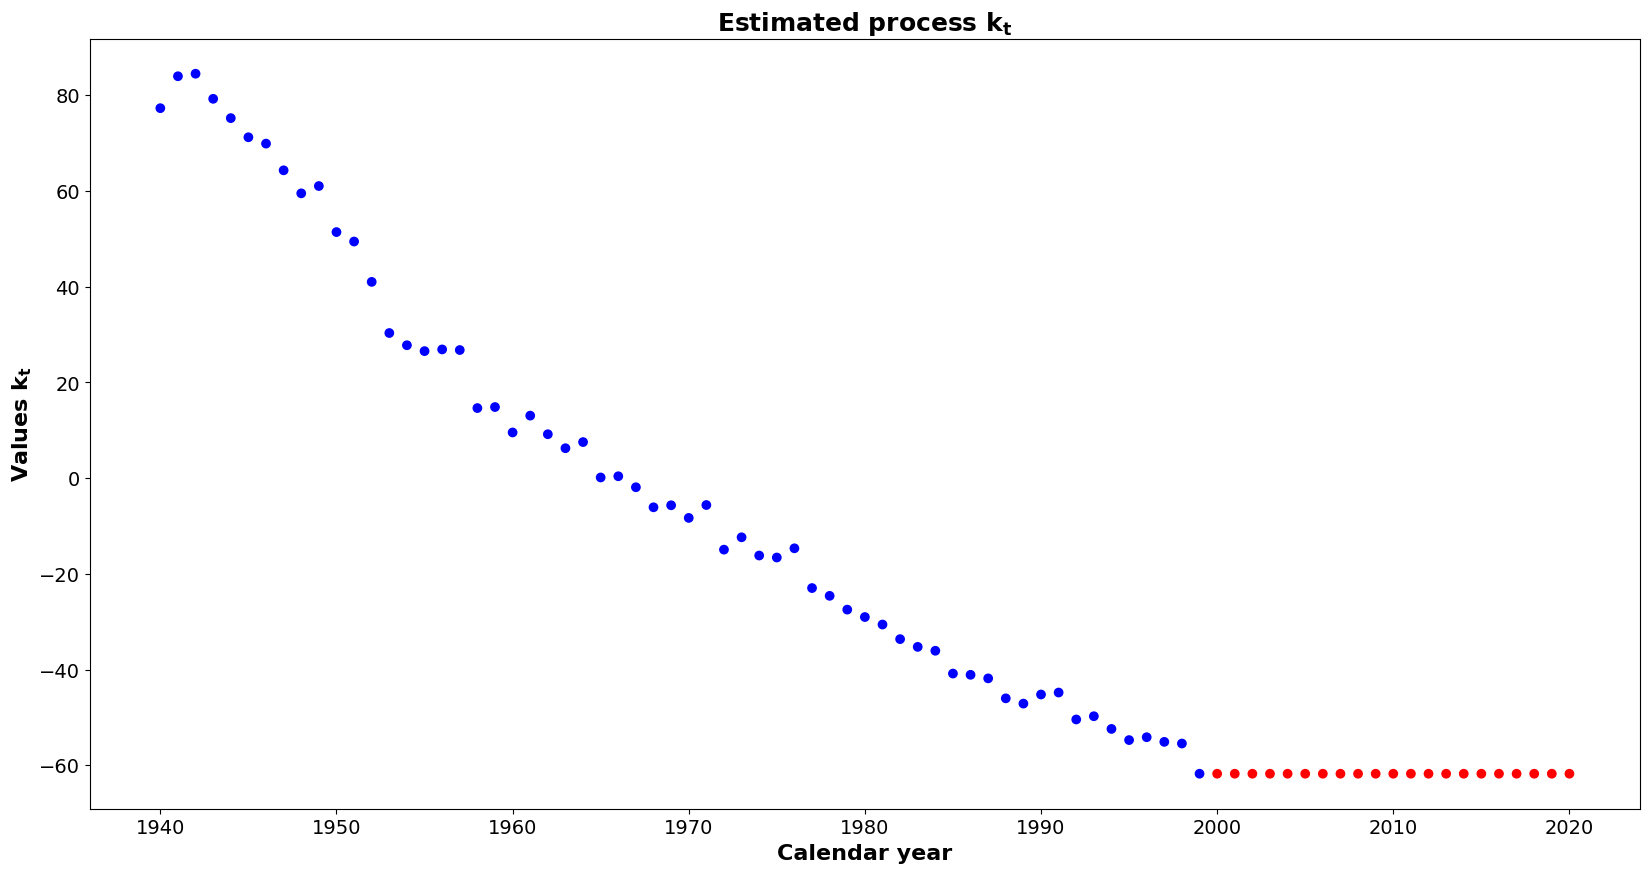

In [42]:
ax_female, bx_female, kt_female = fit_LeeCarter(LC_training_data, 'Female')
kt_forecast_f = LeeCarter_kt_Forecast(LC_validation_data.Year.unique(),kt_female)
train_pred_LC_f = LC_mx_prediction(LC_training_data,ax_female, bx_female, kt_female)
val_pred_LC_f = LC_mx_prediction(LC_validation_data,ax_female, bx_female, kt_forecast_f)

In [43]:
LC_training_data[LC_training_data['Gender'] == 'Female']['mx']

0        0.137274
1        0.047899
2        0.019757
3        0.010181
4        0.006305
           ...   
13193    0.340674
13194    0.351908
13195    0.383093
13196    0.337186
13197    0.375760
Name: mx, Length: 6000, dtype: float64

In [44]:
rmse_train =(mean_squared_error( (LC_training_data[LC_training_data['Gender'] == 'Female'])['mx'], train_pred_LC_f ))*10**4
rmse_val = (mean_squared_error((LC_validation_data[LC_validation_data['Gender'] == 'Female' ])['mx'],val_pred_LC_f))*10**4
print(f'RMSE during training (females) {round(rmse_train,3)}')
print(f'RMSE during testing (females) {round(rmse_val,3)}')

RMSE during training (females) 3.444
RMSE during testing (females) 8.296


#### Male data

<ipython-input-38-89b1ddc56c94>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_logmx_by_age_dict = train_data_by_gender.groupby(by='Age').agg('mean')['logmx'].to_dict()
<ipython-input-38-89b1ddc56c94>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_by_gender['ax'] = train_data_by_gender['Age'].map(mean_logmx_by_age_dict)
<ipython-input-38-89b1ddc56c94>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

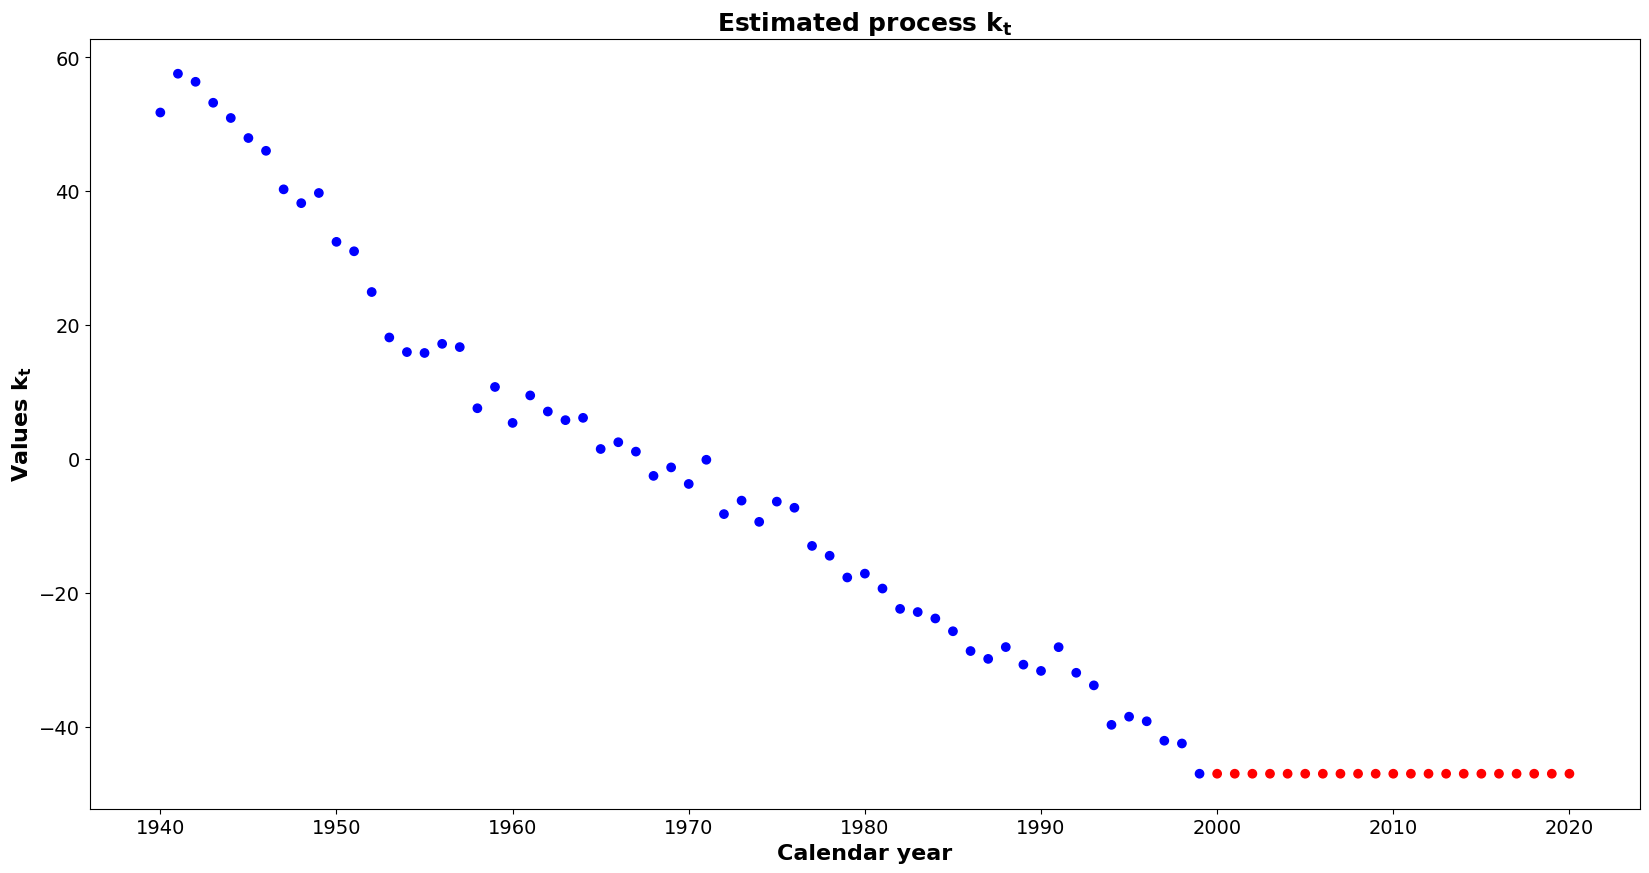

In [45]:
ax_male, bx_male, kt_male = fit_LeeCarter(LC_training_data, 'Male')
kt_forecast_m = LeeCarter_kt_Forecast(LC_validation_data.Year.unique(),kt_male)
train_pred_LC_m = LC_mx_prediction(LC_training_data,ax_male, bx_male, kt_male)
val_pred_LC_m = LC_mx_prediction(LC_validation_data,ax_male, bx_male, kt_forecast_m)

In [46]:
rmse_train =(mean_squared_error( (LC_training_data[LC_training_data['Gender'] == 'Male'])['mx'], train_pred_LC_m ))*10**4
rmse_val = (mean_squared_error((LC_validation_data[LC_validation_data['Gender'] == 'Male' ])['mx'],val_pred_LC_m))*10**4
print(f'RMSE during training (males) {round(rmse_train,3)}')
print(f'RMSE during testing (males) {round(rmse_val,3)}')

RMSE during training (males) 8.462
RMSE during testing (males) 6.471


In [47]:
LC_training_data[LC_training_data['Gender'] == 'Male']

,Year,Age,Gender,mx,logmx
111,1940,0.0,Male,0.152282,-1.882021
112,1940,1.0,Male,0.051148,-2.973032
113,1940,2.0,Male,0.019906,-3.916734
114,1940,3.0,Male,0.009989,-4.606271
115,1940,4.0,Male,0.006830,-4.986431
...,...,...,...,...,...
13304,1999,95.0,Male,0.389900,-0.941865
13305,1999,96.0,Male,0.393385,-0.932967
13306,1999,97.0,Male,0.350473,-1.048472
13307,1999,98.0,Male,0.394333,-0.930560


In [48]:
age=[]
for i in range(0,100):
  age.extend([i])
age = age*21

Year=[]
for i in range(2000,2020+1):
    Year.extend([i]*100)


df_m = pd.DataFrame({ 'Year': Year, 'Age': age,
                          'Gender': ['Male']*2100, 'mx': val_pred_LC_m.to_list(), 'logmx': np.log(val_pred_LC_m.to_list()) })

df_f = pd.DataFrame({ 'Year': Year, 'Age': age,
                          'Gender': ['Female']*2100, 'mx': val_pred_LC_f.to_list(), 'logmx': np.log(val_pred_LC_f.to_list()) })
df_m

pred_LC_df = pd.concat([df_m, df_f])
pred_LC_df

,Year,Age,Gender,mx,logmx
0,2000,0,Male,0.009856,-4.619631
1,2000,1,Male,0.000729,-7.223305
2,2000,2,Male,0.000501,-7.598161
3,2000,3,Male,0.000417,-7.782409
4,2000,4,Male,0.000373,-7.893746
...,...,...,...,...,...
2095,2020,95,Female,0.328387,-1.113564
2096,2020,96,Female,0.364698,-1.008686
2097,2020,97,Female,0.405835,-0.901809
2098,2020,98,Female,0.405655,-0.902253


## LEE CARTER NEW

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import cvxpy as cp
from sklearn.metrics import mean_squared_error
np.random.seed(1)


class LeeCarter:

    def __init__(self, gender: str):
        self.gender = gender
        self.ax = np.array([])
        self.bx = np.array([])
        self.kt = np.array([])

    def fit(self, train_data: pd.DataFrame):

        train_data_by_gender = train_data[ (train_data['Gender'] == self.gender)]

        ## Construction of Centered log-Mortality Matrix
        # Get mean values for log mortality for each age
        mean_logmx_by_age_dict = train_data_by_gender.groupby(by='Age').agg('mean')['logmx'].to_dict()
        train_data_by_gender['ax'] = train_data_by_gender['Age'].map(mean_logmx_by_age_dict)
        train_data_by_gender['mx_adj'] = train_data_by_gender['logmx'] - train_data_by_gender['ax']


        rates_mat = pd.pivot_table(train_data_by_gender, index='Age', columns='Year', values='mx_adj', aggfunc='sum')

        # Singular value decomposition (SVD)
        U, d, V = np.linalg.svd(rates_mat, full_matrices=False )
        V=V.transpose()
        ax = np.array(list(mean_logmx_by_age_dict.values()))
        bx = U[:,0]*d[0]
        kt = V[:,0]

        c1=kt.mean()
        c2=bx.sum()

        # Average log-mortality rate at age x (Lee-Carter formula)
        self.ax = ax + c1*bx
        # Rate of time for a person aged x (Lee-Carter formula)
        self.bx = bx / c2
        # Time indexes for the annual mortality rates chage (Lee-Carter formula)
        self.kt = (kt-c1)*c2


    def kt_forecast(self, num_time_steps: int): #returns kt forecasting
        arima = ARIMA(endog = self.kt,  trend = "t", order=(0, 1, 0))
        fit_arima = arima.fit()
        kt_forecast = fit_arima.forecast(steps = num_time_steps) if num_time_steps != 0 else []

        return kt_forecast


    def predict(self, num_time_steps: int, return_only_prediction: bool = False):
        new_kt = self.kt_forecast(num_time_steps)

        if return_only_prediction:
            kt_to_output = new_kt
        else:
            kt_to_output = np.append(self.kt, new_kt)

        fitted = np.exp(self.ax[:,None] + (self.bx[:,None] @ kt_to_output[None,:]))
        df = pd.melt(pd.DataFrame(fitted))

        output = {'mx': df.value, 'kt_forecast': new_kt}
        return output

    def map_mx_to_kt(self, data: pd.DataFrame):
        year_range = data['Year'].unique()

        data_by_gender = data[data['Gender'] == self.gender]

        data_by_gender['ax'] = data_by_gender['Age'].map(pd.DataFrame(self.ax).to_dict()[0])
        data_by_gender['mx_adj'] = data_by_gender['logmx'] - data_by_gender['ax']
        mat=pd.pivot_table(data_by_gender, index='Age', columns='Year', values='mx_adj', aggfunc='sum')

        new_kt = []
        for year in year_range:
            n = 1 #only one calendar year
            A = - self.bx
            b = - np.array(mat[year])

            # Define and solve the CVXPY problem.
            x = cp.Variable(n)
            cost = cp.sum_squares(A * x - b)
            prob = cp.Problem(cp.Minimize(cost))
            prob.solve()
            new_kt.extend(list(x.value))
        return new_kt




def viz_kt_graph(kt: np.array, kt_forecasts: dict, x_axis_train_values: np.array, x_axis_val_values: np.array, path_to_save_fig: str == None):
        # Plot Settings
        plt.rcParams['figure.figsize']=(10,10)
        plt.rcParams.update({'mathtext.default':  'regular' })
        plt.xlabel('Calendar year',fontsize = 20, fontweight='bold')
        plt.ylabel('Values $k_{t}$',fontsize = 20, fontweight='bold')
        plt.yticks(fontsize = 18)
        plt.xticks(fontsize = 18)
        #plt.title('Estimated process $k_{t}$', fontsize = 20, fontweight='bold')

        #Scatter Plots
        plt.scatter(x = x_axis_train_values, y = kt, c = 'b')
        for id, kt_forecast in kt_forecasts.items():
            c, name = id
            plt.scatter(x = x_axis_val_values, y = kt_forecast, c = c, label = name)


        if path_to_save_fig is not None:
            plt.savefig(path_to_save_fig)
        plt.show()



if __name__ == '__main__':
    country = "PT"
    split_value = 2000
    gender = 'Female'

    leecarter = LeeCarter(gender)





## LSTM

### Restructure of the format of Input

Training: 1950 =< years < 1989

Validation: 1989 <= years < 2000

Test: years >= 2000

Division in **Test**, **Train** and **Validation** sets

In [50]:
df_train = data[(data['Year'] < 1989)].copy()

In [51]:
validation_data = data[(data['Year'] < 2000) & (data['Year'] >= 1989)].copy()

In [52]:
test_data = data[(data['Year'] >= 2000)].copy()



Data preparation

Columns Year, Age, logmx

In [53]:
all_data_mat = pd.crosstab(data['Age'], data['Year'], data['logmx'],aggfunc='sum')

all_data_mat

Year,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Age,,,,,,,,,,,,,,,,,,,,,
0.0,-3.867798,-3.558317,-3.843452,-3.854703,-4.019038,-4.137544,-4.148736,-4.328434,-4.375381,-4.232737,...,-11.625192,-11.438310,-11.778309,-11.750057,-11.665640,-11.485907,-11.922370,-11.427431,-11.751658,-12.090871
1.0,-6.011693,-5.302802,-5.686768,-5.913848,-6.065571,-6.342248,-6.386325,-6.759674,-6.713361,-6.367042,...,-16.382113,-16.967476,-16.533490,-17.066548,-16.883814,-17.193851,-17.076772,-15.873081,-16.304907,-16.772811
2.0,-7.840982,-7.260762,-7.312778,-7.570818,-7.911507,-8.104524,-8.107758,-8.457960,-8.325720,-8.286520,...,-18.119392,-16.982102,-17.112132,-17.452025,-17.150724,-17.503391,-19.010550,-18.031345,-17.222917,-17.702353
3.0,-9.193503,-8.761996,-8.673266,-8.794146,-9.087995,-9.476543,-9.695145,-9.969357,-9.804310,-9.841885,...,-17.946187,-18.052156,-17.663855,-17.476191,-17.895361,-18.169844,-17.324572,-17.902482,-17.501993,-18.484686
4.0,-10.052843,-9.872902,-9.641964,-9.757246,-9.897214,-10.071922,-10.401220,-10.834234,-10.946057,-10.794269,...,-17.727934,-18.861514,-17.799244,-19.782478,-18.629182,-17.927205,-17.667380,-18.201545,-19.014888,-18.893729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95.0,-2.326559,-2.070470,-1.935663,-2.059792,-2.336278,-2.026058,-1.793120,-2.081765,-2.350411,-1.995382,...,-2.612894,-2.342731,-2.492139,-2.583390,-2.593093,-2.570627,-2.543520,-2.451896,-2.418628,-2.285024
96.0,-2.348382,-1.951341,-2.283057,-2.061250,-1.882184,-2.171476,-1.546414,-2.096415,-2.069348,-1.881918,...,-2.381984,-2.384568,-2.330916,-2.473470,-2.418028,-2.277516,-2.374209,-2.359667,-2.209037,-2.095819
97.0,-1.821399,-2.281828,-1.879443,-2.579469,-2.247149,-2.190884,-1.877018,-1.890470,-2.255229,-2.061609,...,-2.180755,-2.020680,-2.099190,-2.401108,-2.250347,-2.248332,-2.285271,-2.144286,-2.148056,-1.838522


In [54]:
train_mat = pd.crosstab(df_train['Year'], df_train['Age'], df_train['logmx'],aggfunc='sum')

In [55]:
tau0=5
T=10

**Padding**

"We choose a fixed gender and we set **tau0** , thus, we smooth feature values over **tau0** neighboring ages to predict the mortality rate of the central age x Since we would like to do this **for all ages** 0<x<99, we need padding at the age boundaries. This is done by duplicating the marginal feature values." (artigo base).
Therefore if **tau=5**, we need to add **2 (delta0) columns in the beginning** and **2 (delta0) columns in the end**.

Variables:
* **df_train_cbind**: dataset with padding (The padding was constructed by adding 2 columns copied from the age corresponding to 0 in the beginning and by adding 2 columns copied from the age corresponding to 99 in the beginning.

In [56]:
def padding(raw_train,T,tau0):

  delta0 = int(np.round((tau0-1)/2))
  padding = [0]*delta0
  padding.extend(np.arange(100))
  padding.extend([99]*delta0)

  padd_train = raw_train.iloc[:,padding]

  #print("Dataset with padding: \n",padd_train)
  return padd_train


Computing the training patterns, with the smooth feature values. We need to set **t0** (in the article is refered as T) which corresponds to the number of smooth features we give to the LSTM.

In [57]:
def LSTM_input_shaping(padd_train,T,tau0):
  t1 = padd_train.shape[0]-(T-1)-1
  a1 = padd_train.shape[1]-(tau0-1)
  #print(padd_train.shape)
  #print(t1,a1)
  n_train = t1 * a1 # number of training samples
  delta0 = int(np.round((tau0-1)/2))

  xtrain = np.empty ((n_train,T,tau0)) #shaping
  xtrain[:] = np.NaN
  ytrain = np.empty((n_train))
  ytrain[:] = np.NaN

  idxs= []
  for t0 in range(0,t1):   # t=time, t0 = 0..39 => year 1950..1990      df_train_cbind.shape = 50,104
    for a0 in range(0,a1): # a=age,  a0=0-99 a0 => age 0..99
      xtrain[(t0)*a1+a0,:,:] = padd_train.iloc[t0:(t0+T),a0:(a0+tau0)].copy()  # copy years from t0 to t0+10 and ages from a0 to a0+5 into xt_train [100*t0+a0, :, :]
      ytrain[(t0)*a1+a0] = padd_train.iloc[t0+T,a0+int(delta0)].copy()
  #print("shaped dataset: \n",xtrain)
  return xtrain,ytrain

In [58]:
#1st :[2000:2009,0:5] idade 0
#2st :[2000:2009,1:6] idade 1
#3st :[2000:2009,2:7] idade 2

Normalization using **MinMaxScale**:

In [59]:
def minMaxScale(data_to_normalize, reference_data):  # MinmaxScale with min and max of reference_data
  xmin = reference_data.to_numpy().min() #comparation between min from Male dataset and Female dataset
  xmax = reference_data.to_numpy().max()
  x_norm = 2*(data_to_normalize-xmin)/(xmin-xmax)-1

  return x_norm

Pre-processing for a **single gender**

In [60]:
def preprocessed_data(raw_data, gender, T, tau0):

  train_gender = raw_data.loc[raw_data['Gender'] == gender].copy()
  train_gender = train_gender[['Year', 'Age', 'logmx']].copy()
  train_gender = pd.crosstab(train_gender['Year'], train_gender['Age'], train_gender['logmx'],aggfunc='sum')

  padd_train= padding(train_gender,T, tau0)

  x,y= LSTM_input_shaping(padd_train,T,tau0)
  x = minMaxScale(x, all_data_mat)
  y = -y

  return x, y

In [61]:
# import pdb
# pdb.set_trace()

Pre-processing for **both genders**

In [62]:
def preprocessing_with_both_genders(raw_data, T, tau0):

    data0 = (preprocessed_data(raw_data, 'Female',T,tau0)) # only training data
    data1 = (preprocessed_data(raw_data, 'Male',T,tau0))
    d = data0[0].shape[0]
    x = np.empty ((2*d,T,tau0)) #shaping
    x[:] = np.NaN
    y = np.empty((2*d))
    y[:] = np.NaN
    gender_indicator = np.array([0,1]*d)

    for i in range(0,d):
      x[(i)*2] = data0[0][i] #odd indexes corresponde to training pattern from the female dataset
      x[(i)*2+1] = data1[0][i] #even indexes corresponde to training pattern from the male dataset
      y[(i)*2] = data0[1][i]
      y[(i)*2+1] = data1[1][i]

    x = [x, gender_indicator]
    return x, y


In [ ]:
x_train_m, y_train_m = preprocessed_data(df_train, 'Male', T, tau0)
x_train_f, y_train_f = preprocessed_data(df_train, 'Female', T, tau0)

x_vali_m, y_vali_m = preprocessed_data(validation_data, 'Male', T, tau0)
x_vali_f, y_vali_f = preprocessed_data(validation_data, 'Female', T, tau0)

print('Female:')
#print('Input of training data: \n {}  \n Output of training data: {}  '.format(x_train_f, y_train_f))
#print('Input  of validation data: \n {} \n Output of validation data: {} '.format(x_vali_f, y_vali_f))

print('Train: \n Input shape: {} \n Output shape: {}  '.format(x_train_f.shape,y_train_f.shape))
print('Validation: \n Input shape: {} \n Output shap: {}   '.format(x_vali_f.shape,  y_vali_f.shape))

print('\n Male:')
#print('Input of training data: \n {}  \n Output of training data: {}  '.format(x_train_m, y_train_m))
#print('Input  of validation data: \n {} \n Output of validation data: {} '.format(x_vali_m, y_vali_m))

print('Train: \n Input shape: {} \n Output shape: {}  '.format(x_train_m.shape,y_train_m.shape))
print('Validation: \n Input shape: {} \n Output shape: {}   '.format(x_vali_m.shape,  y_vali_m.shape))


In [ ]:
x_train_bg, y_train_bg = preprocessing_with_both_genders(df_train, T, tau0)
x_vali_bg, y_vali_bg = preprocessing_with_both_genders(validation_data, T, tau0)
#print('Input of training data: \n {} \n Output of training data: {} '.format(x_train_bg, y_train_bg))
#print('Input of validation data: \n {}  \n Output of validation data: {} '.format(x_vali_bg, y_vali_bg))
#print('Train: \n Input shape: [{},{}] \n Output shape: {}  '.format(x_train_bg[0].shape,x_train_bg[1].shape, y_train_bg.shape))
#print('Validation: \n Input shape: [{},{}] \n Output shape: {}  '.format(x_vali_bg[0].shape, x_vali_bg[1].shape, y_vali_bg.shape))
x_train_bg[1]

In [ ]:
y_train_bg

### Model

#### Arquitecture

##### Model for 1 Gender

In [ ]:
def one_gender_model3(T,tau0,tau1,tau2,tau3,optimizer):
  y0=np.mean(y_train_f) ####REVER ESTE VALOR
  input1 = Input(shape=[T,tau0],name="input")
  lstm1 = LSTM(units=tau1, activation='tanh', recurrent_activation='tanh', return_sequences= True, name ="lstm1")(input1) #20
  lstm2 = LSTM(units=tau2, activation='tanh', recurrent_activation='tanh', return_sequences=True, name ="lstm2")(lstm1) #15
  lstm3 = LSTM(units=tau3, activation='tanh', recurrent_activation='tanh', name ="lstm3")(lstm2) #10
  dense = Dense(units=1, name="Output", activation=backend.exp,
                weights=np.array([np.zeros((10,1)),np.array([np.log(y0)])], dtype='object'))(lstm3) #modificar para o ultimo
  # )

  model = Model(inputs=input1, outputs=dense)
  opt = optimizer # - if we want to improve results - lr=0.0003

  model.compile(optimizer=opt, loss='mean_squared_error')
  return model


In [ ]:
model_female = one_gender_model3(T,tau0,20,15,10,Adam(learning_rate=0.001, beta_1= 0.9, beta_2=0.999, ))
model_male = one_gender_model3(T,tau0,20,15,10,Adam(learning_rate=0.001, beta_1= 0.9, beta_2=0.999, ))

In [ ]:
plot_model(model_female, to_file='female_model_plot.png', show_shapes=True, show_layer_names=True)

##### **Both genders** Model

In [ ]:
y0=4.585904379419358 # Constant
## Input layers
input1 = Input(shape=(10,5),name="input")
Gender = Input(shape=(1),name="Gender")
## LSTM layers
lstm1 = LSTM(units=20, activation='tanh', recurrent_activation='tanh', return_sequences= True, name ="lstm1")(input1) #20
lstm2 = LSTM(units=15, activation='tanh', recurrent_activation='tanh', return_sequences=True, name ="lstm2")(lstm1) #15
lstm3 = LSTM(units=10, activation='tanh', recurrent_activation='tanh', name ="lstm3")(lstm2) #10
## Concatenate LSTM layers with the gender input layer
concat = Concatenate(axis=1,name='Concat')([lstm3, Gender])
## Output layer
dense = Dense(units=1, name ="Output", activation = backend.exp,  weights=np.array([np.zeros((11,1)),np.array([np.log(y0)])], dtype='object')
          )(concat)


uni_model = Model(inputs=[input1, Gender], outputs=dense)
#radam = RectifiedAdam()
#ranger = Lookahead(radam, sync_period=6, slow_step_size=0.5)
#opt=ranger
#opt = SGD(learning_rate=0.001, momentum=0.001) # - if we want to improve results - lr=0.0003
opt = Adam(learning_rate=0.001, beta_1= 0.9, beta_2=0.999, )
uni_model.compile(optimizer=opt, loss='mean_squared_error')

In [ ]:
"""
import joblib

filename = '/home/lmv/Documents/Everis/bc_insurance_mx'
uni_model.save(filename)
uni_model = tf.keras.models.load_model(filename)"""


In [ ]:
#Baseline:
def both_gender_model(tau1,tau2,tau3):

    y0=np.mean(y_train_bg) ####REVER ESTE VALOR
    input1 = Input(shape=(T,tau0),name="input")
    Gender = Input(shape=(1),name="Gender")

    lstm1 = LSTM(units=tau1, activation='tanh', recurrent_activation='sigmoid', return_sequences= True, name ="LSTM1")(input1) #20
    lstm2 = LSTM(units=tau2, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, name ="LSTM2")(lstm1) #15
    lstm3 = LSTM(units=tau3, activation='tanh', recurrent_activation='sigmoid', name ="LSTM3")(lstm2) #10
    concat = Concatenate(axis=1,name='Concat')([lstm3, Gender])
    dense = Dense(units=1, name ="Output", activation = backend.exp,  weights=np.array([np.zeros((11,1)),np.array([np.log(y0)])], dtype='object')
                  )(concat) #modificar para o ultimo


    uni_model = Model(inputs=[input1, Gender], outputs=dense)
    #radam = RectifiedAdam()
    #ranger = Lookahead(radam, sync_period=6, slow_step_size=0.5)
    #opt=ranger
    #opt = SGD(learning_rate=0.001, momentum=0.001) # - if we want to improve results - lr=0.0003
    opt = Adam(learning_rate=0.001, beta_1= 0.9, beta_2=0.999, )
    uni_model.compile(optimizer=opt, loss='mean_squared_error')
    return uni_model


In [ ]:
uni_model = both_gender_model(20,15,10)
#uni_model.compile(optimizer=Adam(learning_rate=0.001, beta_1= 0.9, beta_2=0.999, ), loss='mean_squared_error')

In [ ]:
plot_model(uni_model, to_file='./Plot_model/uni_model_gru_plot.png', show_shapes=True, show_layer_names=True)

**Some remarks and Sources:**
Bidirectional LSTM: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/
Stacked LSTM: "An extension of a single hidden layer LSTM to a multiple hidden layer LSTM architecture is rather straightforward. First, we need to adjust the first LSTM layer so that the neuron activations of all time points are output (and not only for the last time point T). This is achieved by the **command return sequences=TRUE**": base article
EarlyStopping and Checkpoints: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

#### Fitting and Hyperparameters

In [ ]:
#os.chdir('/home/lmv/Documents/Everis/bc_insurance_mx/Model_checkpoints')

##### **1-Gender Model**

**Male** fitting for 1-gender model

In [ ]:
"""checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only = True)
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50) #addition of early stopping
callbacks_list = [checkpoint,earlystop]"""

In [ ]:
filepath="model_male_best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only = True)
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50) #addition of early stopping
callbacks_list = [checkpoint,earlystop]
#model_male.fit(x=x_train_m, y=y_train_m, validation_data=( x_vali_m , y_vali_m ),epochs=500, batch_size=100, verbose=1, callbacks=callbacks_list) # Model checkpoint CallBack --- validation_split=0.2,


**Female** fitting for 1-gender model

In [ ]:
filepath="model_female_best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only = True)
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50) #addition of early stopping
callbacks_list = [checkpoint,earlystop]
#model_female.fit(x=x_train_f, y=y_train_f, validation_data=( x_vali_f , y_vali_f ),epochs=500, batch_size=100, verbose=1, callbacks=callbacks_list) # Model checkpoint CallBack --- validation_split=0.2,


##### **Universal Model**

In [ ]:
filepath="./Model_checkpoints/uni_model_best_weights.hdf5"
#uni_model = both_gender_model(20,15,10)
#uni_model.compile(optimizer=Adam(learning_rate=0.001, beta_1= 0.9, beta_2=0.999, ), loss='mean_squared_error')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only = True)
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50) #addition of early stopping
callbacks_list = [checkpoint,earlystop]
uni_model.fit(x = x_train_bg, y = y_train_bg,validation_split=0.2 #validation_data = ( x_vali_bg , y_vali_bg )
,epochs=500, batch_size=100, verbose=1, callbacks=callbacks_list) # Model checkpoint CallBack

**Bidirectional** Both-Gender Model

#### Train Evolution/In-Sample loss

In [ ]:
#os.chdir('/home/lmv/Documents/Everis/bc_insurance_mx')

In [ ]:
uni_model.history.history

In [ ]:
def plot_loss_evolution(model, name):
  plt.rcParams['figure.figsize']=(10,10)
  plt.plot(model.history.history['loss'])
  plt.plot(model.history.history['val_loss'])
  #plt.title('model loss')
  plt.xlabel('epoch',fontsize = 20, fontweight='bold')
  plt.ylabel('loss',fontsize = 20, fontweight='bold')
  plt.yticks(fontsize = 18)
  plt.xticks(fontsize = 18)
  #plt.ylim(0,0.1)
  plt.legend(['train', 'validation'], loc='upper right',fontsize = 18)
  plt.savefig(name)
  return plt.show()

In [ ]:
def in_sample_MSE(xtrain,ytrain,model):
  real_train = np.exp(-model.predict(xtrain, verbose =0))
  pred_train =  np.exp(-ytrain)
  return (mean_squared_error(real_train,pred_train))

In [ ]:
plot_loss_evolution(uni_model, name = 'uni_model_lstm.pdf')
plot_loss_evolution(model_female, name = 'model_female_lstm.pdf')
plot_loss_evolution(model_male, name = 'model_male_lstm.pdf')

### Forecasting of the LSTM

Forecast of the mortality per year and age from **first_year** to **last_year**

In [ ]:
def recursive_forecast(first_year,last_year, T , model, gender):
  modelType_dict = { 'Male', 'Female' }
  ObsYear = 1999 #last obs year
  # first window of T=10 years to predict the first year ( (ObsYear-T) to ObsYear => predicts ObsYear+1):
  mortality = data[(data['Year'] <= ObsYear)].copy() #Observed data so far
  mortality = mortality[['Year', 'Age','mx', 'logmx', 'Gender']].copy()

  if gender in modelType_dict:

    for  year in range(ObsYear+1, last_year+1): # The next year is recursively predicted
      mort = mortality[( mortality['Year'] >= (year-T-1))].copy() #selection of only the last T years

      x_mort, y_mort = preprocessed_data( mort, gender, T, tau0)

      # Construction of prediction table for the test set:
      predicted = pd.DataFrame({ 'Year': ([year]*100), 'Age': range(0,100), 'Gender': [gender]*100})
      model_pred= (model.predict(x_mort, verbose =0)) #prediction of the model
      predicted['logmx'] = -model_pred #substitution of real values for predicted ones
      predicted['mx'] = np.exp(-model_pred)

      # Construction of dataframe for the values that we are going to keep for the next iteration
      keep =  pd.DataFrame(mortality.copy())
      mortality= keep.append(predicted)

  else:
    print('Gender type not found.')
  prediction = (mortality[( mortality['Year'] >= (first_year)) ].copy())
  return prediction

#import pdb
#pdb.set_trace()

In [ ]:
def recursive_forecast_both_genders(first_year,last_year,T, model, gender = 'Both'):
  ObsYear = 1999 #last obs year

  # first window of T=10 years to predict the first year ( (ObsYear-T) to ObsYear => predicts ObsYear+1):
  mortality = data[(data['Year'] <= ObsYear)].copy()
  mortality = mortality[['Year', 'Age','mx', 'logmx', 'Gender']].copy()

  for  year in range(ObsYear+1, last_year+1): # The next year is recursively predicted
    mort = mortality[( mortality['Year'] >= (year-T-1))].copy() #selection of only the last T years
    x_mort, y_mort = preprocessing_with_both_genders(mort, T, tau0)

    l=[]
    for i in range(0,100):
      l.extend([i]*2)

    predicted = pd.DataFrame({ 'Year': ([year]*200), 'Age': l,
                              'Gender': pd.Categorical((x_mort[1]).tolist()).rename_categories(['Female','Male']) })


    # Construction of prediction table for the test set:
    model_pred= (model.predict(x_mort, verbose=0)) #prediction of the model
    predicted['logmx'] = -model_pred #substitution of real values for predicted ones
    predicted['mx'] = np.exp(-model_pred)

    # Construction of dataframe for the values that we are going to keep for the next iteration
    keep =  pd.DataFrame(mortality.copy())
    mortality= keep.append(predicted)

  prediction = (mortality[( mortality['Year'] >= (first_year)) ].copy())
  if gender in {'Male', 'Female'}:
    prediction = prediction[prediction['Gender'] == gender]

  return prediction



In [ ]:
d=recursive_forecast_both_genders(2026,2026,T, uni_model, gender = 'Female')
d[ (d['Age'] == 10.0) & (d['Year']== 2026 )]

### Evaluation of the model

In [ ]:
real_test_male = (test_data[test_data['Gender'] == 'Male']).copy()['mx']
real_test_female = (test_data[test_data['Gender'] == 'Female']).copy()['mx']

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
model = uni_model

In [ ]:
print('both gender model:',np.round(in_sample_MSE(x_train_bg,y_train_bg,model)*10**4,3))
pred_test_male = recursive_forecast_both_genders(2000,year_max, T, model,'Male')['mx']
print('both gender out-sample male:',np.round(mean_squared_error(real_test_male.to_numpy(),pred_test_male.to_numpy())*10**4,3))
pred_test_female = recursive_forecast_both_genders(2000,year_max, T, model,'Female')['mx']
print('both gender out-sample female:',np.round(mean_squared_error(real_test_female.to_numpy(),pred_test_female.to_numpy())*10**4,3))

In [ ]:
model = model_female

In [ ]:
print('both gender model:',np.round(in_sample_MSE(x_train_f,y_train_f,model)*10**4,3))
pred_test_male = recursive_forecast(2000,year_max, T, model,'Male')['mx']
print('both gender out-sample male:',np.round(mean_squared_error(real_test_male.to_numpy(),pred_test_male.to_numpy())*10**4,3))
pred_test_female = recursive_forecast(2000,year_max, T, model,'Female')['mx']
print('both gender out-sample female:',np.round(mean_squared_error(real_test_female.to_numpy(),pred_test_female.to_numpy())*10**4,3))

In [ ]:
model = model_male

In [ ]:
print('both gender model:',np.round(in_sample_MSE(x_train_m,y_train_m,model)*10**4,3))
pred_test_male = recursive_forecast(2000,year_max, T, model,'Male')['mx']
print('both gender out-sample male:',np.round(mean_squared_error(real_test_male.to_numpy(),pred_test_male.to_numpy())*10**4,3))
pred_test_female = recursive_forecast(2000,year_max, T, model,'Female')['mx']
print('both gender out-sample female:',np.round(mean_squared_error(real_test_female.to_numpy(),pred_test_female.to_numpy())*10**4,3))

In [ ]:
#print(np.random.get_state())

Code for saving weights for later use:
(source: https://machinelearningmastery.com/save-load-keras-deep-learning-models/)

### Hyperparameter Tuning

In [ ]:
!pip install --upgrade keras-hypetune


In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate
from keras.optimizers import Adam
from keras import backend

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
from kerashypetune import KerasGridSearch, KerasGridSearchCV, KerasRandomSearch, KerasRandomSearchCV


In [ ]:
# Define the Keras model function
def create_model(param):
    y0 = 4.585904379419358  # Constant



    # Input layers
    input1 = Input(shape=(10, 5), name="input")
    Gender = Input(shape=(1), name="Gender")

    # LSTM layers
    lstm1 = LSTM(units= param['unit0'], activation='tanh', recurrent_activation='tanh', return_sequences=True,
                 name="lstm1")(input1)
    lstm2 = LSTM(units=param['unit1'], activation='tanh', recurrent_activation='tanh', return_sequences=True,
                 name="lstm2")(lstm1)
    lstm3 = LSTM(units=param['unit2'], activation='tanh', recurrent_activation='tanh', name="lstm3")(lstm2)

    # Concatenate LSTM layers with the gender input layer
    concat = Concatenate(axis=1, name='Concat')([lstm3, Gender])

    # Output layer
    dense = Dense(units=1, name="Output", activation=backend.exp,
                  weights=np.array([np.zeros((param['unit2']+1, 1)), np.array([np.log(y0)])], dtype='object'))(concat)

    uni_model = Model(inputs=[input1, Gender], outputs=dense)
    opt = Adam(learning_rate= param['learning_rate'], beta_1=0.9, beta_2=0.999)
    uni_model.compile(optimizer=opt, loss='mean_squared_error')

    return uni_model


# Generate sample input data
X = np.random.rand(7800, 10, 5)
gender = np.random.rand(7800, 1)
y = np.random.rand(7800, 1)

# Create the KerasClassifier wrapper
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'unit0':[15,20,25],
    'unit1':[10,15,25],
    'unit2':[5,10,15],  # Possible values for LSTM units
    'learning_rate': [0.001, 0.01, 0.1]  # Possible learning rates
}

# Perform grid search
#grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
#grid_result = grid.fit([X, gender], y)  # Replace X and y with your input data
es = EarlyStopping(patience=500, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)


kgs = KerasGridSearch(create_model,param_grid=param_grid,  greater_is_better=False,tuner_verbose=1)
kgs.search([X,gender], y, callbacks=[es], validation_split=0.2)

# Print the best results
print("Best parameters: ", kgs.best_params)
print("Best score: ", kgs.best_score)

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate
from keras.optimizers import Adam
from keras import backend

def create_model(unit0,unit1,unit2, learning_rate):
    y0 = 4.585904379419358  # Constant

    # Input layers
    input1 = Input(shape=(10, 5), name="input")
    #Gender = Input(shape=(1), name="Gender")

    # LSTM layers
    lstm1 = LSTM(units=unit0, activation='tanh', recurrent_activation='tanh', return_sequences=True,
                 name="lstm1")(input1)
    lstm2 = LSTM(units=unit1, activation='tanh', recurrent_activation='tanh', return_sequences=True,
                 name="lstm2")(lstm1)
    lstm3 = LSTM(units=unit2, activation='tanh', recurrent_activation='tanh', name="lstm3")(lstm2)

    # Concatenate LSTM layers with the gender input layer
    #concat = Concatenate(axis=1, name='Concat')([lstm3, Gender])

    # Output layer
    dense = Dense(units=1, name="Output", activation=backend.exp,
                  weights=np.array([np.zeros((unit2, 1)), np.array([np.log(y0)])], dtype='object'))(lstm3)

    uni_model = Model(inputs=input1, outputs=dense)
    opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    uni_model.compile(optimizer=opt, loss='mean_squared_error')

    return uni_model

# Create the KerasRegressor wrapper
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'unit0':[10,15,20,25],
    'unit1':[10,15,20,25],
    'unit2':[10,15,20,25],
    'learning_rate': [0.001, 0.01, 0.1]  # Possible learning rates
}

# Generate sample input data
X = np.random.rand(7800, 10, 5)
y = np.random.rand(7800, 1)

# Reshape y to match the model output shape
y = np.expand_dims(y, axis=-1)

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X, y)  # Pass inputs as a list

# Print the best results
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)


In [ ]:
kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_accuracy', greater_is_better=True, tuner_verbose=1)
kgs.search(x_train, y_train, validation_data=(x_test, y_test), callbacks=[es])

In [ ]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method
plot_grid_search(pipe_grid.cv_results_, [15,20,25,30], [10,15,20,25], 'unit0', 'unit1')

In [ ]:
grid_result.cv_results_

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate
from keras.optimizers import Adam
from keras import backend

# Define the Keras model function
def create_model(units, learning_rate):
    y0 = 4.585904379419358  # Constant

    # Input layers
    input1 = Input(shape=(10, 5), name="input")
    Gender = Input(shape=(1), name="Gender")

    # LSTM layers
    lstm1 = LSTM(units=units[0], activation='tanh', recurrent_activation='tanh', return_sequences=True,
                 name="lstm1")(input1)
    lstm2 = LSTM(units=units[1], activation='tanh', recurrent_activation='tanh', return_sequences=True,
                 name="lstm2")(lstm1)
    lstm3 = LSTM(units=units[2], activation='tanh', recurrent_activation='tanh', name="lstm3")(lstm2)

    # Concatenate LSTM layers with the gender input layer
    concat = Concatenate(axis=1, name='Concat')([lstm3, Gender])

    # Output layer
    dense = Dense(units=1, name="Output", activation=backend.exp,
                  weights=np.array([np.zeros((11, 1)), np.array([np.log(y0)])], dtype='object'))(concat)

    uni_model = Model(inputs=(input1, Gender), outputs=dense)
    opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    uni_model.compile(optimizer=opt, loss='mean_squared_error')

    return uni_model

# Create the KerasRegressor wrapper
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'units': [(20, 15, 10), (30, 20, 15)],  # Possible values for LSTM units
    'learning_rate': [0.001, 0.01, 0.1]  # Possible learning rates
}

# Generate sample input data
X = np.random.rand(7800, 10, 5)
y = np.random.rand(7800, 1)

# Reshape y to match the model output shape
y = np.expand_dims(y, axis=-1)

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit( (X, np.zeros((X.shape[0], 1))), y)  # Pass inputs as a list

# Print the best results
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)


In [ ]:
(y_train_bg).reshape(y_train_bg.shape[0],1).shape

In [ ]:
x_train_bg[0].shape

### Best Model

In [ ]:
from tensorflow.keras.models import model_from_json

In [ ]:

# serialize model to JSON
model_json = uni_model.to_json()
with open("LSTM3_u40_uni_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
"""
uni_model.save_weights("uni_model1_432-0_46.h5")
print("Saved model to disk")
"""

In [ ]:
#json_file = open('./best_model/LSTM3_u40_uni_model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(uni_model.to_json())
# load weights into new model
uni_model.load_weights("./best_model/uni_model1_432-0_46.h5")
print("Loaded model from disk")

In [ ]:
from datetime import datetime
#gender
validation_test_data = male_validation_data
gender = 'Male'
pred_test=recursive_forecast(2000,year_max, T, model,gender)


leecarter = LeeCarter(gender)
leecarter.fit(LC_training_data)

validation_test_kt = leecarter.map_mx_to_kt(data = validation_test_data)
pred_test_kt = leecarter.map_mx_to_kt(data = pred_test)
year_range_train = LC_training_data['Year'].unique()
year_range_val = validation_test_data['Year'].unique()

kt_forecasts = { ('r', 'LSTM Both Genders') : pred_test_kt }#, ('b', None) : validation_test_kt}

# Evaluation
viz_kt_graph(kt = leecarter.kt, kt_forecasts = kt_forecasts, x_axis_train_values = year_range_train, x_axis_val_values = year_range_val, path_to_save_fig = f'lstmmalegenders_{gender}_{country}_' + str(datetime.now()) + '.pdf')


## N-BEATS

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")

os.chdir("../../..")

In [ ]:
!pip install -U pytorch_lightning


In [ ]:
!pip install -U pytorch_forecasting


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch
import pytorch_forecasting
from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

In [ ]:
torch.__version__

### Restruture of the format of input

In [ ]:
gender = 'Female'

In [ ]:
data_nbeats = data.astype({'Age': 'int32'})
data_nbeats['Year'] = data_nbeats['Year'].sub(1940)
data_nbeats_f = data_nbeats[ data_nbeats['Gender'] == gender ]
data_nbeats_f

In [ ]:
# create dataset and dataloaders
max_encoder_length = 10
max_prediction_length = 15

training_cutoff = data_nbeats_f["Year"].max() - 2*(max_prediction_length)
validation_cutoff = data_nbeats_f["Year"].max() - (max_prediction_length)


context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data_nbeats_f[lambda x: x.Year <= training_cutoff],
    time_idx="Year",
    target="logmx",
    #categorical_encoders={"Age": NaNLabelEncoder().fit(data_nbeats_f.Age)},
    group_ids=["Age"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["logmx"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data_nbeats_f[lambda x: x.Year <= validation_cutoff], min_prediction_idx=training_cutoff + 1)
test = TimeSeriesDataSet.from_dataset(training,data_nbeats_f, min_prediction_idx=validation_cutoff + 1)

batch_size = 100
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


In [ ]:
(validation)

In [ ]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=0, gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=False, suggest=True)
#fig.show()
net.hparams.learning_rate = res.suggestion()
lr = res.suggestion()

### Fitting

In [ ]:

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=50, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)


net = NBeats.from_dataset(
    training,
    learning_rate=lr,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 100],
    backcast_loss_ratio=1.0,
)
#net.save_hyperparameters('batch_size', 'learning_rate')

trainer.fit(
    net,
    train_dataloader = train_dataloader,
    val_dataloaders = val_dataloader,
)


### Evaluation of the Model

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [ ]:
actuals_train = torch.cat([y[0] for x, y in iter(train_dataloader)])
predictions_train = best_model.predict(train_dataloader)
print('in-sample MSE:', np.around( (actuals_train - predictions_train).square().mean().numpy()*10**4 ,3) )

In [ ]:
actuals_val = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions_val = best_model.predict(val_dataloader)
print('validation MSE:', np.around( (actuals_val - predictions_val).square().mean().numpy()*10**4  ,3) )

In [ ]:
actuals_test = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions_test = best_model.predict(test_dataloader)
print('out-of-sample MSE:', np.around( (actuals_test - predictions_test).square().mean().numpy()*10**4  ,3) )

In [ ]:
raw_predictions, x = best_model.predict(test_dataloader, mode="raw", return_x=True)

In [ ]:
#for idx in range(10):  # plot 10 examples
best_model.plot_prediction(x, raw_predictions, idx=99, add_loss_to_title=True);

### N-Beats Interpretability

In [ ]:
#for idx in range(10):  # plot 10 examples
 #   best_model.plot_interpretation(x, raw_predictions, idx=idx);

In [ ]:
plt.figure()
best_model.plot_interpretation(x, raw_predictions, idx=19);
plt.savefig('/home/lmv/Documents/Everis/bc_insurance_mx/Plot_model/nBeats19.jpeg')


# Prediction Visualization

data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()# Lee Carter vs LSTM (Plot)

In [ ]:
prediction_bg_m = recursive_forecast_both_genders(2000,year_max, T, uni_model,'Male')
prediction_og_m = recursive_forecast(2000,year_max, T, model_male,'Male')

prediction_bg_f = recursive_forecast_both_genders(2000,year_max, T, uni_model,'Female')
prediction_og_f = recursive_forecast(2000,year_max, T, model_female,'Female')

In [ ]:
def kt_LSTM(gender, prediction):

  if gender == 'Male':
    mean_logmx = mean_logmx_by_age_dict_m
    bx = bx_male
  elif gender == 'Female':
    mean_logmx = mean_logmx_by_age_dict_f
    bx = bx_female

  prediction['ax'] = prediction.Age.map(mean_logmx)
  prediction['mx_adj'] = prediction.logmx - prediction.ax
  mat=pd.pivot_table(prediction, index='Age', columns='Year', values='mx_adj', aggfunc='sum')

  kt_LSTM=[]
  for year in range(2000,year_max+1):
    # Generate data.
    m = 100
    n = 1
    np.random.seed(1)
    A = -bx
    b = -np.array(mat[year])

    # Define and solve the CVXPY problem.
    x = cp.Variable(n)
    cost = cp.sum_squares(A * x - b)
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve()
    kt_LSTM.append(float(x.value))
  return kt_LSTM

kt_LSTM_bg_m = kt_LSTM('Male', prediction_bg_m)

In [ ]:
kt_LSTM_bg_m = kt_LSTM('Male', prediction_bg_m)
kt_LSTM_og_m = kt_LSTM('Male', prediction_og_m)

kt_LSTM_bg_f = kt_LSTM('Female', prediction_bg_f)
kt_LSTM_og_f = kt_LSTM('Female', prediction_og_f)

kt_test_f = kt_LSTM('Female', test_data[test_data['Gender'] == 'Female'])
kt_test_m = kt_LSTM('Male', test_data[test_data['Gender'] == 'Male'])

In [ ]:
sns.set(style = "darkgrid")

# Plot Male kt
plt.figure()
plt.rcParams['figure.figsize']=(20,10)
plt.rcParams.update({'mathtext.default':  'regular' })
t_forecast=np.arange(2000,year_max+1)
x=np.append(np.arange(year_min,2000), t_forecast)
y=np.append(kt_male, kt_forecast_m)
#forecast_col = np.append(np.zeros(len(kt_male)), np.ones(len(kt_forecast_m)))
plt.scatter(x=t_forecast, y=kt_LSTM_bg_m , c='g', label="LSTM both genders") # forecast for LSTM both genders for Males
plt.scatter(x=t_forecast, y=kt_LSTM_og_m , c='y', label="LSTM one gender") # forecast for LSTM one genders for Males
plt.scatter(x=t_forecast, y=kt_forecast_m, c='r',label="Lee Carter")
plt.scatter(x=np.arange(year_min,2000), y=kt_male, c='b')
plt.scatter(x=np.arange(2000,year_max+1), y=kt_test_m, c='b')
plt.legend(loc="lower left")
plt.xlabel('Calendar year',fontsize = 16, fontweight='bold')
plt.ylabel('Values $k_{t}$',fontsize = 16, fontweight='bold')
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.title('Estimated process $k_{t}$ for Males',fontsize = 18, fontweight='bold')
#plt.savefig('Plot-Models/LC-RNN-males.pdf')
plt.show()


# Plot Female kt
plt.figure()
plt.rcParams['figure.figsize']=(20,10)
plt.rcParams.update({'mathtext.default':  'regular' })
x=np.append(np.arange(year_min,2000), t_forecast)
y=np.append(kt_female, kt_forecast_f)
#forecast_col = np.append(np.zeros(len(kt_female)), np.ones(len(kt_forecast_f)))
plt.scatter(x=t_forecast, y=kt_LSTM_bg_f , c='g', label="LSTM both genders") # forecast for LSTM both genders for Females
plt.scatter(x=t_forecast, y=kt_LSTM_og_f , c='y',label="LSTM one gender") # forecast for LSTM one genders for Females
plt.scatter(x=np.arange(year_min,2000), y=kt_female, c='b')
plt.scatter(x=t_forecast, y=kt_forecast_f, c='r',label="Lee Carter")
plt.scatter(x=np.arange(2000,year_max+1), y=kt_test_f, c='b')

plt.legend(loc="lower left")
plt.xlabel('Calendar year',fontsize = 16, fontweight='bold')
plt.ylabel('Values $k_{t}$',fontsize = 16, fontweight='bold')
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.title('Estimated process $k_{t}$ for Females',fontsize = 18, fontweight='bold')
#plt.savefig('Plot-Models/LC-RNN-females.pdf')
plt.show()


In [ ]:
pred_test_male_mat

In [ ]:
df_pred_test_female= recursive_forecast_both_genders(2000,year_max, T, uni_model, 'Female')
pred_test_female_mat = pd.crosstab(df_pred_test_female['Year'], df_pred_test_female['Age'], df_pred_test_female['logmx'],aggfunc='sum')
pred_test_female_mat

df_pred_test_male= recursive_forecast_both_genders(2000,year_max, T, uni_model, 'Male')
pred_test_male_mat = pd.crosstab(df_pred_test_male['Year'], df_pred_test_male['Age'], df_pred_test_male['logmx'],aggfunc='sum')

df_pred_test= recursive_forecast_both_genders(2000,year_max, T, uni_model)
pred_test_mat = pd.crosstab(df_pred_test['Year'], df_pred_test['Age'], df_pred_test['mx'],aggfunc='sum')
log_pred_test_mat = pd.crosstab(df_pred_test['Year'], df_pred_test['Age'], df_pred_test['logmx'],aggfunc='sum')

In [ ]:
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.grid(False)
im1= ax1.imshow((pred_test_female_mat.to_numpy()), cmap='tab20c', interpolation='nearest',vmin=-11,vmax=0) #cmap choices: tab20c, prism, flag
fig1.colorbar(im1, ticks=[ -11, 0],
              fraction=0.03,
              pad=0.04
              ).ax.tick_params(labelsize=16)
locs, labels = plt.yticks()
labels = [int(item)+2000 for item in locs]
plt.yticks(locs, labels, fontsize = 16)
plt.xticks(fontsize = 16)
#plt.title("Heatmap of Predicted Female Mortality Rate")
plt.ylim([0,20])
plt.xlim([0,99])
plt.xlabel("Age", fontsize = 16, fontweight='bold')
plt.ylabel("Year", fontsize = 16, fontweight='bold')
plt.savefig('heatmatFemalePredict.pdf')
#plt.savefig('/home/lmv/Documents/Everis/bc_insurance_mx/Plot_model/heatmatFemalePredict.jpeg')

plt.show()


fig2, ax2 = plt.subplots(figsize=(10,10))
ax2.grid(False)
im2= ax2.imshow((pred_test_male_mat.to_numpy()), cmap='tab20c', interpolation='nearest',vmin=-11,vmax=0) #cmap choices: tab20c, prism, flag
fig2.colorbar(im2, ticks=[ -11, 0],
              fraction=0.03,
              pad=0.04).ax.tick_params(labelsize=16)
locs, labels = plt.yticks()
labels = [int(item)+2000 for item in locs]
plt.yticks(locs, labels, fontsize = 16)
plt.xticks(fontsize = 16)
#plt.title("Heatmap of Predicted Male Mortality Rate")
plt.ylim([0,20])
plt.xlim([0,99])
plt.xlabel("Age", fontsize = 16, fontweight='bold')
plt.ylabel("Year", fontsize = 16, fontweight='bold')
plt.savefig('heatmatMalePredict.pdf')
#plt.savefig('/home/lmv/Documents/Everis/bc_insurance_mx/Plot_model/heatmatMalePredict.jpeg')

plt.show()


In [ ]:
x

In [ ]:
data2000to2020 = data[(data['Year']>=2000) & (data['Year'] <= 2020)]
data2000to2020_mat = pd.crosstab(data2000to2020['Year'], data2000to2020['Age'], data2000to2020['mx'],aggfunc='sum')
log_data2000to2020_mat = pd.crosstab(data2000to2020['Year'], data2000to2020['Age'], data2000to2020['logmx'],aggfunc='sum')

In [ ]:
data2020_pred = pred_test_mat.loc[2020]
data2020 = data2000to2020_mat.loc[2020]

mx_p = data2020_pred.to_list()
mx_r = data2020.to_list()

dmf = pd.DataFrame({'Age' : range(0,100),
     'Pred mx' : mx_p,
     'Real mx' : mx_r})

plt.figure()
plt.scatter(x=dmf['Age'], y=dmf['Pred mx'], c='r', label='LSTM prediction')
plt.scatter(x=dmf['Age'], y=dmf['Real mx'],c='g', label ='Real data')
plt.legend()
plt.ylabel("Mortality Rate")
plt.xlabel("Age")
plt.title("Real & Predicted Mortality evolution in 2020")
#plt.savefig('Plot-Exp/Pred&RealMort2020.pdf')
#plt.savefig('/home/lmv/Documents/Everis/bc_insurance_mx/Plot_model/Pred&RealMort2020.jpeg')

plt.show()

log_mx_p = (log_pred_test_mat.loc[2020]).to_list()
log_mx_r = (log_data2000to2020_mat.loc[2020]).to_list()

dmf = pd.DataFrame({'Age' : range(0,100),
     'Pred logmx' : log_mx_p,
     'Real logmx' : log_mx_r})


plt.figure()
plt.scatter(x=dmf['Age'], y=dmf['Pred logmx'], c='r', label='LSTM prediction')
plt.scatter(x=dmf['Age'], y=dmf['Real logmx'],c='g', label ='Real data')
plt.legend()
plt.ylabel("log-Mortality Rate")
plt.xlabel("Age")
plt.title("Real & Predicted log-Mortality evolution in 2020")
#plt.savefig('Plot-Exp/Pred&RealLogMort2020.pdf')
#plt.savefig('/home/lmv/Documents/Everis/bc_insurance_mx/Plot_model/Pred&RealLogMort2020.jpeg')

plt.show()

In [ ]:
df_pred_test

In [ ]:
((df_pred_test.groupby(['Year','Age']).mean()).index).values

In [ ]:
Year=[]
Age=[]
for index in list(((df_pred_test.groupby(['Year','Age']).mean()).index).values):
  Year.append(index[0])
  Age.append(index[1])

In [ ]:
df_pred_test.groupby(['Year','Age']).mean()

In [ ]:
Year_real=[]
Age_real=[]
for index in list(((test_data.groupby(['Year','Age']).mean()).index).values):
  Year_real.append(index[0])
  Age_real.append(index[1])

In [ ]:
test_data

In [ ]:
test_data.groupby(['Year','Age']).mean()

In [ ]:
pred_LC_df.groupby(['Year','Age']).mean()

In [ ]:

df_pred_test.groupby(['Year','Age']).mean()


In [ ]:
from matplotlib.ticker import LinearLocator
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D

sns.set(style = "darkgrid")

df_pred_test_bg=df_pred_test.groupby(['Year','Age']).mean()
test_data_bg=test_data.groupby(['Year','Age']).mean()
pred_LC_df_bg = pred_LC_df.groupby(['Year','Age']).mean()


fig = plt.figure()

ax = fig.add_subplot(111, projection = '3d')
#ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.9, 1, 1]))

x = Age
y = list(map(int, Year))
z = df_pred_test_bg['logmx']
plt.xticks(rotation=90)
ax.set_xlabel("Age")
ax.set_ylabel("Year")
ax.set_zlabel("logmx", rotation=20)
ax.plot_trisurf(x, y, z, cmap=cm.jet)
ax.xaxis.set_major_locator(MaxNLocator(10))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.view_init(20, 360-90)
plt.savefig('3DplotPred.pdf')
#plt.savefig('/home/lmv/Documents/Everis/bc_insurance_mx/Plot_model/3DplotPred.jpeg')

plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
x1 = Age_real
y1 = Year_real
z1 = test_data_bg['logmx']
ax.set_xlabel("Age")
ax.set_ylabel("Year")
ax.set_zlabel("logmx")
ax.plot_trisurf(x1, y1, z1, cmap=cm.jet)
ax.xaxis.set_major_locator(MaxNLocator(10))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.view_init(20, 360-90)
plt.savefig('3DplotReal.pdf')
#plt.savefig('/home/lmv/Documents/Everis/bc_insurance_mx/Plot_model/3DplotReal.jpeg')

plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
x1 = Age_real
y1 = Year_real
z1 = pred_LC_df_bg['logmx']
ax.set_xlabel("Age")
ax.set_ylabel("Year")
ax.set_zlabel("logmx")
ax.plot_trisurf(x1, y1, z1, cmap=cm.jet)
ax.xaxis.set_major_locator(MaxNLocator(10))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.view_init(20, 360-90)
plt.savefig('3DplotReal.pdf')
#plt.savefig('/home/lmv/Documents/Everis/bc_insurance_mx/Plot_model/3DplotLC.jpeg')

plt.show()


In [ ]:
m1 = np.array((test_data[test_data['Gender']=='Female'])['mx'].to_list())
m2 = np.array((df_pred_test[df_pred_test['Gender']=='Female'])['mx'].to_list())

f, ax = plt.subplots(1)
sm.graphics.mean_diff_plot(m1, m2, ax = ax)
plt.title('Bland-Altman Plot for Female', fontsize=16)
#plt.savefig('Plot-Exp/BlandAltmanFemale.pdf')
#plt.savefig('/home/lmv/Documents/Everis/bc_insurance_mx/Plot_model/BlandAltmanFemale.jpeg')
plt.show()

In [ ]:
m1 = np.array((test_data[test_data['Gender']=='Male'])['mx'].to_list())
m2 = np.array((df_pred_test[df_pred_test['Gender']=='Male'])['mx'].to_list())

f, ax = plt.subplots(1)
sm.graphics.mean_diff_plot(m1, m2, ax = ax)
plt.title('Bland-Altman Plot for Males', fontsize=16)
#plt.savefig('Plot-Exp/BlandAltmanMale.pdf')
#plt.savefig('/home/lmv/Documents/Everis/bc_insurance_mx/Plot_model/BlandAltmanMale.jpeg')

plt.show()

'Female'Para o **Power BI**: https://www.youtube.com/watch?v=ahf6wPXHTvM

**Shap** : https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html

# Explainability

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [ ]:
x_test_bg, y_test_bg = preprocessing_with_both_genders(test_data, T, tau0)

In [ ]:
[max(min(i,99),0) for i in range(97,102)]

In [ ]:
def explain_scores_heatmap(mat, beg_year, middle_age, vmin, vmax, explain_method = 'Explanability Score', cmap='hot'):
  fig = plt.figure(figsize=(6, 4))
  ax = sns.heatmap(mat, linewidth=0.5 ,vmin=vmin, vmax = vmax, cmap=cmap, xticklabels=range(beg_year,beg_year+10), yticklabels=[max(min(i,99),0) for i in range(middle_age - 2, middle_age +2 +1)])
  # Adjust the fontsize of the plot
  fontsize = 14
  ax.tick_params(axis='x', labelsize=9)
  ax.tick_params(axis='y', labelsize=9)
  ax.set_xlabel('Calendar year', fontsize=18)
  ax.set_ylabel('Age', fontsize=18)
  plt.savefig(f'{explain_method}_heatmap_plot_{beg_year}_{middle_age}_{gender}.pdf', bbox_inches = 'tight')
  plt.show()

In [ ]:
def explain_scores_per_age_plot(list_of_arrays,label=['Female', 'Male'],color=['r', 'b'], gender ='both', year = 2011, explain_method = 'ExplanabilityScore' ):
  plt.figure(figsize=(11,8))
  for i in range(len(list_of_arrays)):
    plt.plot(np.arange(0,100),list_of_arrays[i], color = color[i], label= label[i])
  plt.tick_params(axis='x', labelsize=16)
  plt.tick_params(axis='y', labelsize=16)
  plt.xlabel('Age',fontsize=18, weight='bold')
  plt.ylabel(explain_method,fontsize=18, weight='bold')
  plt.savefig(f'{gender}_{explain_method}_values_{year}.pdf')
  plt.show()

In [ ]:
def get_instance(data, instance_idx):
  mx, gender = data
  return [mx[instance_idx:instance_idx+1], gender[instance_idx:instance_idx+1]]

## Keras Kernel Shap

*Texto em itálico*# Kernel SHAP Keras

In [ ]:
!pip install shap
#!pip install numba --upgrade
import shap

In [ ]:
def model_wrapper(inputs):
    num_samples = inputs.shape[0]
    # Split the combined input into separate inputs
    gender = inputs[:, -1]
    inputs = inputs[:, :-1].reshape(num_samples, 10, 5)

    # Perform the model prediction using the separate inputs
    predictions = model.predict([inputs, gender])  # Adjust according to your model's prediction function

    return predictions

In [ ]:
def flat_input(input):
  mx, gender = input
  samples_num = mx.shape[0]
  feature_size = mx.shape[1] * mx.shape[2]
  mx = mx.reshape(samples_num, feature_size)
  gender = gender.reshape(samples_num, 1)
  return np.append(mx, gender, axis=1)

In [ ]:
def feature_names(beg_year, middle_age,gender):
  feature_names = []
  for year in range(beg_year, beg_year+10):
    for age in range(middle_age - 2, middle_age +2 +1):
      age = max(age, 0)
      age = min(age, 99)
      feature_names.append(f"({year},{age})")
  feature_names.append(f'{gender}')
  return feature_names

In [ ]:
model = uni_model

In [ ]:
beg_year, middle_age = 2001, 13
gender = 'Male'
gender_idx = 1 if gender == 'Male' else 0
instance_idx = ((beg_year - 2000)*99 + middle_age ) * 2 + gender_idx
instance_idx

In [ ]:
feature_size = 5*10
train_data_exp = x_train_bg
test_data_exp = x_test_bg

In [ ]:
instance = get_instance(test_data_exp, instance_idx)
reshaped_instance_with_gender = flat_input(instance)
reshaped_instance_with_gender.shape

In [ ]:
reshaped_train_with_gender = flat_input(train_data_exp)
reshaped_train_with_gender.shape

In [ ]:
explainer = shap.KernelExplainer(model_wrapper, shap.sample(reshaped_train_with_gender, 10))

In [ ]:
shap_values = explainer.shap_values(reshaped_instance_with_gender)


In [ ]:
shap_values

In [ ]:
plt.figure(figsize=(8,8))
summary_fig = shap.summary_plot(shap_values, features=reshaped_instance_with_gender, feature_names = feature_names(beg_year, middle_age,gender), show=False, plot_size=[8,8]) #Previsão de idade 2 ano 2010(Age, Year)
# Adjust the fontsize of the plot
fontsize = 14
plt.gca().legend([])
plt.gca().tick_params(axis='x', labelsize=fontsize)
plt.gca().tick_params(axis='y', labelsize=fontsize)
plt.gca().set_xlabel('Absolute Shapley values', fontsize=18)
plt.gca().set_ylabel('Calendar year and Age', fontsize=18)
plt.savefig(f'shap_bar_plot_{beg_year}_{middle_age}_{gender}.pdf', bbox_inches = 'tight')

# Show the plot
plt.show()


In [ ]:
shap_values[0][:,-1]

In [ ]:
shapmat = np.abs(np.transpose(shap_values[0][:,:-1].reshape(10,5)))
shapmat

In [ ]:
explain_scores_heatmap(shapmat, beg_year, middle_age, vmin=0, vmax=np.max(shapmat))

In [ ]:
beg_year = 2001
male = []
female = []


for age in range(0, 99+1):
  instance_idx_f = ((beg_year - 2000)*99 + age ) * 2
  instance_idx_m = ((beg_year - 2000)*99 + age ) * 2 +1

  instance_f = get_instance(test_data_exp, instance_idx_f)
  instance_m = get_instance(test_data_exp, instance_idx_m)
  reshaped_instance_with_gender_f = flat_input(instance_f)
  reshaped_instance_with_gender_m = flat_input(instance_m)

  shap_values_m = explainer.shap_values(reshaped_instance_with_gender_m)
  shap_values_f = explainer.shap_values(reshaped_instance_with_gender_f)

  male.append(np.abs(shap_values_m[0][:,-1]))
  female.append(np.abs(shap_values_f[0][:,-1]))

male
female

In [ ]:
explain_scores_per_age_plot([male, female], year = 2011,explain_method = 'Shapley values' )

## Keras Integrated Gradients

In [ ]:
model = uni_model

In [ ]:
beg_year, middle_age = 2000, 80
gender = 'Male'
gender_idx = 1 if gender == 'Male' else 0
instance_idx = ((beg_year - 2000)*99 + middle_age ) * 2 + gender_idx
instance = [np.squeeze(x) for x in get_instance(x_vali_bg, instance_idx)]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

# Define the integrated gradients function
def integrated_gradients(model, inputs, num_steps=50):
    # Define the baseline inputs
    baseline_inputs = [np.zeros_like(input_data) for input_data in inputs]

    # Calculate the path integral step size
    alpha = np.arange(1, num_steps + 1) / num_steps

    # Compute the gradients along the path from baseline to the inputs
    interpolated_inputs = [
        [baseline_input + alpha[i] * (input_data - baseline_input) for i in range(num_steps)]
        for baseline_input, input_data in zip(baseline_inputs, inputs)
    ]
    interpolated_inputs = [
        tf.convert_to_tensor(interpolated_input, dtype=tf.float32)
        for interpolated_input in interpolated_inputs
    ]

    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        predictions = model(interpolated_inputs)

    gradients = tape.gradient(predictions, interpolated_inputs)

    # Calculate the average gradients
    avg_gradients = [
        tf.reduce_mean(gradient, axis=0)
        for gradient in gradients
    ]

    # Compute the integrated gradients
    integrated_grads = [
        (input_data - baseline_input) * avg_gradient
        for input_data, baseline_input, avg_gradient in zip(inputs, baseline_inputs, avg_gradients)
    ]

    return integrated_grads

In [ ]:
ig = integrated_gradients(model, instance)

In [ ]:
ig_mx, ig_gender = ig
igmat = np.abs(np.transpose(ig_mx))
explain_scores_heatmap(igmat, beg_year, middle_age,vmin=0, vmax=np.max(igmat) , explain_method ='IntegratedGradients', cmap = 'hot')

In [ ]:
beg_year = 2000
gender = 'Male'
gender_idx = 1 if gender == 'Male' else 0
gender_scores = []

for age in range(0, 99+1):
  instance_idx = ((beg_year - 2000)*99 + age ) * 2 + gender_idx
  instance = [np.squeeze(x) for x in get_instance(x_vali_bg, instance_idx)]
  ig_mx, ig_gender = integrated_gradients(model, instance)
  gender_scores.append(float(ig_gender))

gender_scores

In [ ]:
explain_scores_per_age_plot(gender_scores,gender='Female', year = 2011, explain_method = 'IntegratedGradients' )

#Captum Attempt

In [ ]:
!pip install captum onnx


In [ ]:

import torch
import pandas as pd

from torch import tensor
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, IntegratedGradients, GradientShap
import matplotlib.pyplot as plt
import numpy as np

class ExplainableMortalityRate():
    """Wrapper for Captum framework"""

    def __init__(self, name:str, model):
        self._name = name
        self._model = model


    def forward_func(self,xe: tensor, xd: tensor, ind: tensor):
        """
            Wrapper around prediction method of model
        """
        pred = self._model(xe, xd, ind)

        return pred[:, -1,:].squeeze(1)

    def visualize(self, attributes: list, dim_to_visualize:int,indexes:list = None):
        """
            Visualization method.
            Takes list of inputs and correspondent attributs for them to visualize in a barplot
        """
        attr_sum = attributes.sum(dim_to_visualize)

        attr = attr_sum / torch.norm(attr_sum)

        if indexes is None:
            index_size = len(attr.numpy()[0])
            indexes = list(map(str, np.arange(index_size)))


        a = pd.Series(attr.numpy()[0],
                         index = indexes)
        print(a)
        a.plot.barh()

    def explain(self, inputs: tuple, dim_to_explain: int = 1, batched_input: bool = True):
        """
            Main entry method. Passes input through series of transformations and through the model.
            Calls visualization method.
        """

        int_grad = GradientShap(self.forward_func)
        if batched_input:
            inputs = pt.unbatchify(inputs)

        baselines = self.generate_baseline(inputs)
        (xe_atr, xd_atr, ind_atr) = int_grad.attribute(inputs = inputs, baselines = baselines)

        self.visualize( xe_atr, dim_to_explain)
        #self.visualize( xd_atr, dim_to_explain)
        #self.visualize( ind_atr, dim_to_explain)

    def generate_baseline(self, inputs: tuple) -> tensor:
        """
            Convenience method for generation of baseline vector as tuple of torch tensors zeros
        """
        return tuple( map(lambda x: torch.zeros(size = x.size()) if x is not None else None, inputs))



In [ ]:
def from_numpy_to_torch(t: tuple) -> tuple:
    """Transformer tuple of Numpy arrays to tuple of torch arrays.

    Args:
        t (tuple): tuple of numpy arrays to convert.

    Returns:
        Tuple of torch tensors.
    """
    return tuple(map(lambda x: torch.from_numpy(x).float() if x is not None else None, t))

def unbatchify(inputs: tuple) -> tuple:
        """
        Unbatchify tuples of inputs
        """
        return tuple( map(lambda x: x.view(1, -1, *(x.size()[2:])).squeeze(0) if x is not None else None, inputs))

def get_pattern(unbatch_input: tuple, i: int) -> tuple:
    return unbatch_input[0][i, :, :].unsqueeze(0), unbatch_input[1][i, :, :].unsqueeze(0), unbatch_input[2][i].unsqueeze(0) if unbatch_input[2] is not None else None, unbatch_input[3][i].unsqueeze(0)


In [ ]:
uni_model.load_weights("./best_model/uni_model1_432-0_46.h5")
print("Loaded model from disk")

In [ ]:
tf.saved_model.save(uni_model, 'tmp')
!python -m tf2onnx.convert --saved-model tmp --output ./best_model/uni_model1_432-0_46.onnx --opset 13

In [ ]:
import onnx
onnx_model_path = "./best_model/uni_model1_432-0_46.onnx"
best_model = onnx.load_model(onnx_model_path)

In [ ]:
type(best_model)

In [ ]:
import onnx
from onnx2pytorch import ConvertModel

onnx_model = onnx.load(onnx_model_path)
pytorch_model = ConvertModel(onnx_model)

In [ ]:
torch_model = torch.nn.Module()
torch_model.load_state_dict(best_model.state_dict())

In [ ]:
best_model(x_train_bg)

In [ ]:
len(x_train_bg)

In [ ]:
# Explain Model

unbatch_input = unbatchify(test_data)

In [ ]:
# Explain Model
unbatch_input = unbatchify(test_data)

sample_index = 1
dim_to_explain = 1
sample = get_pattern(unbatch_input, sample_index)
best_model.explain(sample, batched_input = False, dim_to_explain = dim_to_explain)
print()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Define the Integrated Gradients function
def integrated_gradients(inputs, baseline, model, target_class_index, steps=50):
    inputs = tf.cast(inputs, tf.float32)
    baseline = tf.cast(baseline, tf.float32)
    interpolated_inputs = [baseline + (i / steps) * (inputs - baseline) for i in range(steps + 1)]

    gradients = []
    for interpolated_input in interpolated_inputs:
        with tf.GradientTape() as tape:
            tape.watch(interpolated_input)
            logits = model(interpolated_input)
            target_class_logits = logits[0, target_class_index]
        gradients.append(tape.gradient(target_class_logits, interpolated_input))

    avg_gradients = tf.reduce_mean(gradients, axis=0)
    integrated_gradients = (inputs - baseline) * avg_gradients
    return integrated_gradients


# Prepare the input and baseline data
input_data = x_train
baseline_data = [np.zeros(x_train[0].shape), np.zeros(x_train[0].shape)]

# Compute Integrated Gradients for a specific target class index
target_class_index = y_train  # Change this to your desired target class index
integrated_gradients = integrated_gradients(input_data, baseline_data, model, target_class_index)

# Normalize the integrated gradients
normalized_gradients = (integrated_gradients - tf.reduce_min(integrated_gradients)) / (
    tf.reduce_max(integrated_gradients) - tf.reduce_min(integrated_gradients)
)

# Visualize the integrated gradients as a heatmap overlay
heatmap = np.sum(normalized_gradients, axis=-1)
plt.imshow(heatmap, cmap='jet', alpha=0.8)
plt.imshow(input_data[0], alpha=0.5)
plt.axis('off')
plt.show()